#Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 4.0 MB/s eta 0:00:00


In [3]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 446.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 43.9 MB/s eta 0:0

In [4]:
import pandas as pd
import numpy as np
from scipy import stats

from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import torch

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

from darts import TimeSeries
from darts.utils.statistics import plot_acf, check_seasonality
from darts.models import NaiveDrift, NaiveSeasonal, XGBModel, ExponentialSmoothing, AutoARIMA, Theta, ARIMA, Prophet, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts import concatenate
from darts.utils.statistics import plot_hist



from google.colab import drive

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


#Function

In [6]:
# Функція для обчислення середнього значення і довірчого інтервалу
def mean_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    n = len(data)
    stderr = stats.sem(data)
    h = stderr * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean, mean - h, mean + h

In [7]:
def lineplot_stores(df):
    sns.set_theme(style="darkgrid")

    # Перший графік: продажі товарів
    sns.lineplot(x="year", y="sales", hue="store", data=df)

    # Налаштування заголовка і відображення графіків
    plt.suptitle('Порівняння продажів товару по магазинам', fontsize=16)
    plt.tight_layout()
    plt.show()

def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

def fit_eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    eval_forecast(model, val, forecast)


def plot_results(series, forecast):
  # Візуалізація результатів
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);


def enrich_with_date_features(df):
  # Feature Extraction
  df["month"] = df['date'].dt.month
  df["year"] = df['date'].dt.year
  df["dayofweek"] = df['date'].dt.dayofweek
  #df["sin_day"] = np.sin(df["dayofyear"])
  #df["cos_day"] = np.cos(df["dayofyear"])
  df["dayofmonth"] = df['date'].dt.day
  return df


#Data

In [8]:
path_to = '/content/drive/MyDrive/Python/ML/DATA/Kaggle/TS/train.csv.zip'

У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

#Завдання 1

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [9]:
#1.1
#зчитування даних
data = pd.read_csv(path_to)

In [10]:
#1.2
data['date'] = pd.to_datetime(data['date'])

In [ ]:
data["month"] = data['date'].dt.month
data["year"] = data['date'].dt.year
data["dayofmonth"] = data['date'].dt.day

In [11]:
#1.3
data.set_index('date', inplace=True)

In [ ]:
#1.4
display(data.head(10))

,store,item,sales,month,year,dayofmonth
date,,,,,,
2013-01-01,1,1,13,1,2013,1
2013-01-02,1,1,11,1,2013,2
2013-01-03,1,1,14,1,2013,3
2013-01-04,1,1,13,1,2013,4
2013-01-05,1,1,10,1,2013,5
2013-01-06,1,1,12,1,2013,6
2013-01-07,1,1,10,1,2013,7
2013-01-08,1,1,9,1,2013,8
2013-01-09,1,1,12,1,2013,9


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   store       913000 non-null  int64
 1   item        913000 non-null  int64
 2   sales       913000 non-null  int64
 3   month       913000 non-null  int32
 4   year        913000 non-null  int32
 5   dayofmonth  913000 non-null  int32
dtypes: int32(3), int64(3)
memory usage: 38.3 MB


#Завдання 2

  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



чи відрізняється динаміка по кожному айтему в магазинах

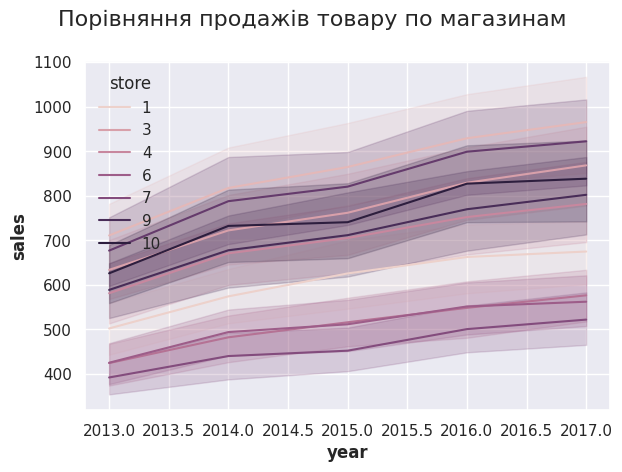

In [ ]:
df_item_1 = data[data['item'] == 1]
month_sales = df_item_1.groupby(['store', 'year', 'month']).agg({'sales': 'sum'}).reset_index()
lineplot_stores(month_sales)


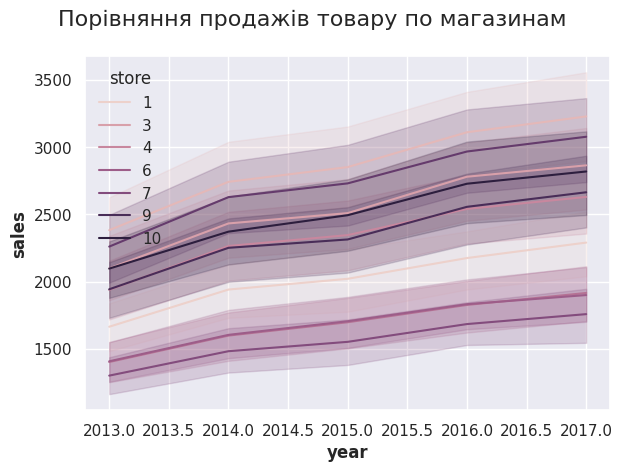

In [ ]:
df_item_1 = data[data['item'] == 10]
month_sales = df_item_1.groupby(['store', 'year', 'month']).agg({'sales': 'sum'}).reset_index()
lineplot_stores(month_sales)

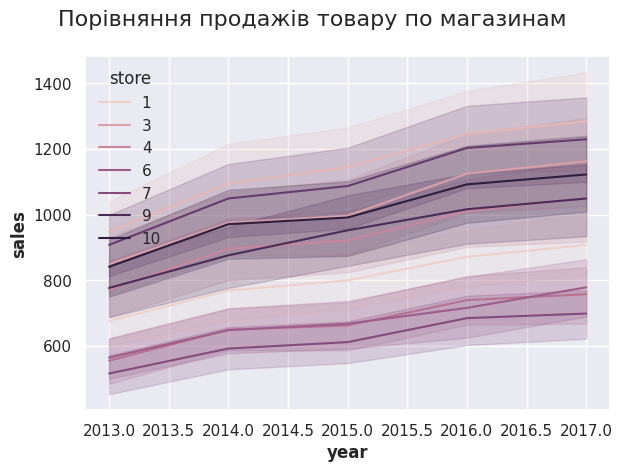

In [ ]:
df_item_1 = data[data['item'] == 40]
month_sales = df_item_1.groupby(['store', 'year', 'month']).agg({'sales': 'sum'}).reset_index()
lineplot_stores(month_sales)

#Завдання 3

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [12]:
df_1_1 = data[(data['item']==1)&(data['store']==1)]
df_1_1_2017 = df_1_1['2017-01-01':'2017-12-31']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   store       913000 non-null  int64
 1   item        913000 non-null  int64
 2   sales       913000 non-null  int64
 3   month       913000 non-null  int32
 4   year        913000 non-null  int32
 5   dayofmonth  913000 non-null  int32
dtypes: int32(3), int64(3)
memory usage: 38.3 MB


##seasonal_decompose

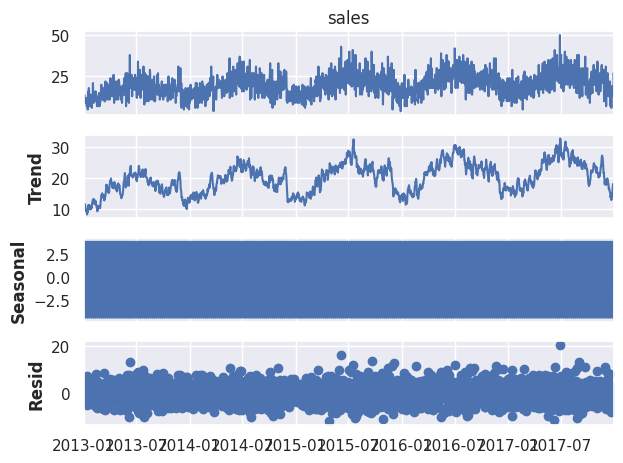

In [ ]:
# Візуалізація адитивної декомпозиції для часового ряду
decomposition_plot_multi = seasonal_decompose(df_1_1['sales'],
                                              model='additive')
decomposition_plot_multi.plot()
plt.show()

дані лише за 2017 рік

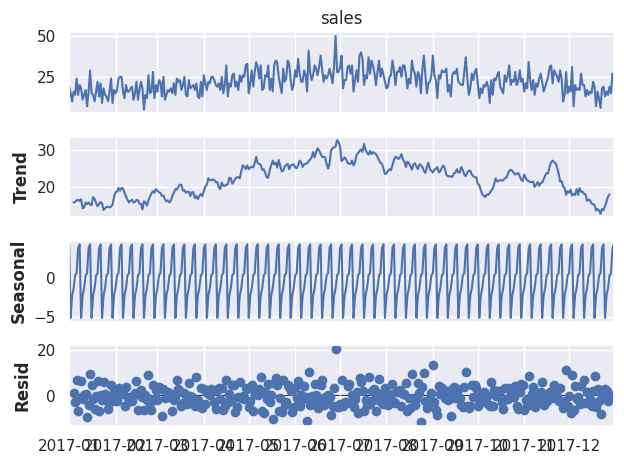

In [ ]:
# Візуалізація адитивної декомпозиції для часового ряду
decomposition_plot_multi = seasonal_decompose(df_1_1_2017['sales'],
                                              model='additive')
decomposition_plot_multi.plot()
plt.show()

##STL

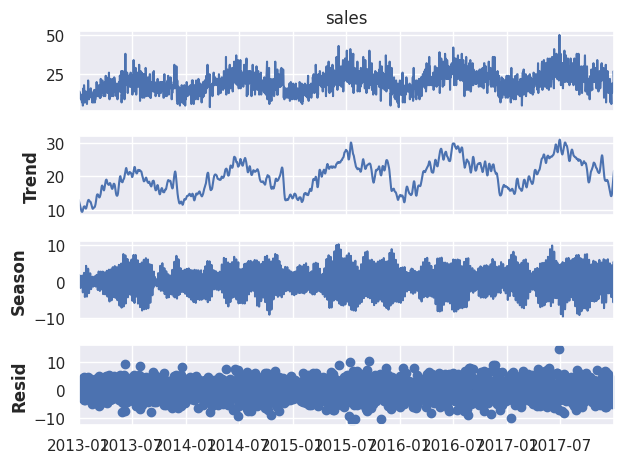

In [ ]:
res = STL(df_1_1['sales']).fit()
res.plot()
plt.show()

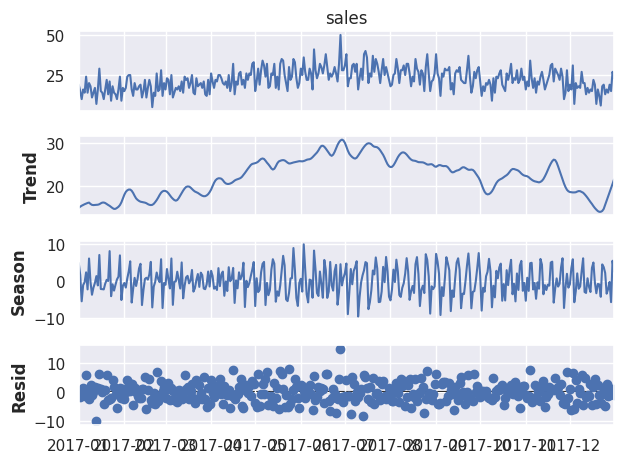

In [ ]:
res = STL(df_1_1_2017['sales']).fit()
res.plot()
plt.show()

##pd.rolling

In [ ]:
df_mult = df_1_1.copy(deep=True)

# рахуємо тренд згладжуючи ряд з річним вікном розміром 13
df_mult["trend"] = df_1_1['sales'].rolling(window=14, center=True).mean()

# віднімаємо тренд з даних
df_mult["detrended"] = df_1_1['sales'] - df_mult["trend"]

# рахуємо сезонну складову як середнє значення ряду пілся віднімання тренду
df_mult["month"] = df_mult.index.month
df_mult["seasonality"] = df_mult.groupby("date")["detrended"].transform("mean")

# обчислюємо залишок як все, що ми не змогли пояснити сезонністю
df_mult["resid"] = df_mult["detrended"] - df_mult["seasonality"]


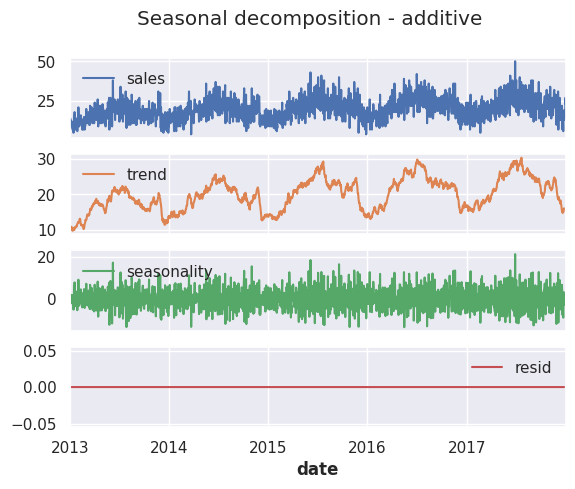

In [ ]:
(
    df_mult
    .loc[:, ["sales", "trend", "seasonality", "resid"]]
    .plot(subplots=True, title="Seasonal decomposition - additive")
);

дані лише за 2017 рік

In [ ]:
df_mult_2017 = df_1_1_2017.copy(deep=True)

# рахуємо тренд згладжуючи ряд з річним вікном розміром 13
df_mult_2017["trend"] = df_1_1_2017['sales'].rolling(window=14, center=True).mean()

# віднімаємо тренд з даних
df_mult_2017["detrended"] = df_1_1_2017['sales'] - df_mult_2017["trend"]

# рахуємо сезонну складову як середнє значення ряду пілся віднімання тренду
df_mult_2017["month"] = df_mult_2017.index.month
df_mult_2017["seasonality"] = df_mult_2017.groupby("date")["detrended"].transform("mean")

# обчислюємо залишок як все, що ми не змогли пояснити сезонністю
df_mult_2017["resid"] = df_mult_2017["detrended"] - df_mult_2017["seasonality"]

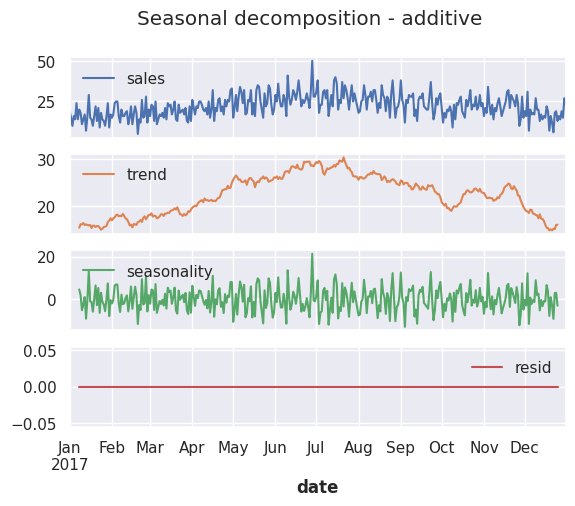

In [ ]:
(
    df_mult_2017
    .loc[:, ["sales", "trend", "seasonality", "resid"]]
    .plot(subplots=True, title="Seasonal decomposition - additive")
);

**Висновки:**
- seasonal_decompose - При візуалізації на данних за кілька років не справився з виявленням сезонностію. В той же час при візуалізації на одному році - сезонність стабільна
- STL по іншому розподілив дані між трендом та сезонністю: більш згладений тренд, але не така стабільна сезонність.
- розрахунок через pandas не виявив зовсім шуми

#Завдвння 4

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [13]:
series = TimeSeries.from_dataframe(df_1_1, value_cols='sales')

#Завдання 5

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

<Axes: xlabel='date'>

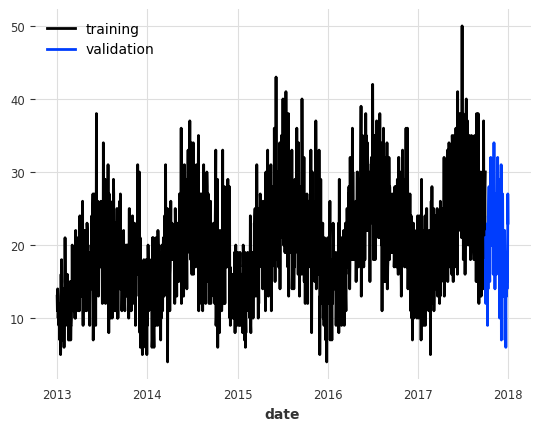

In [14]:
train, val = series.split_before(pd.Timestamp("2017-10-01"))
train.plot(label="training")
val.plot(label="validation")

#Завдання 6

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

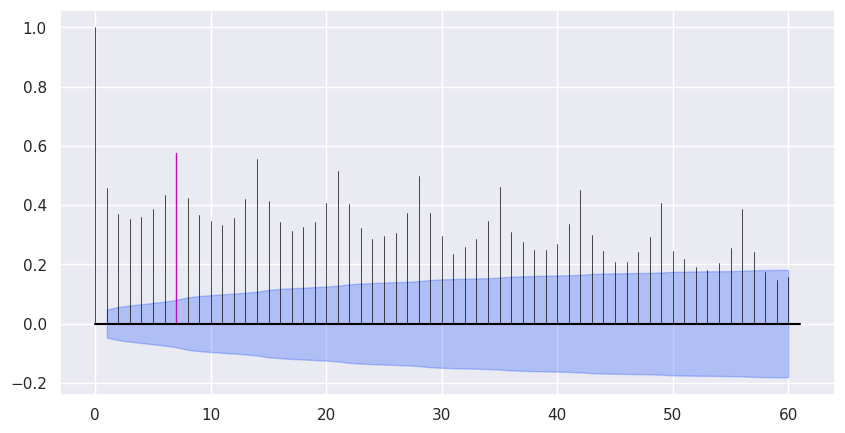

In [ ]:
plot_acf(train, m=7, alpha=0.05, max_lag=60)

#check_seasonality з darts

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [ ]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


#NaiveSeasonal + NaieDrift

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

##Модель на всьому тренувальному наборі

<Axes: xlabel='date'>

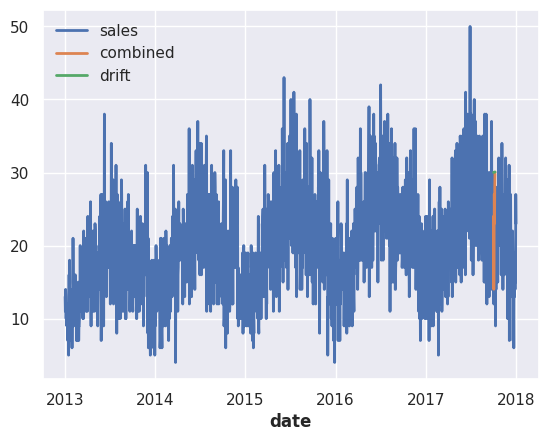

In [ ]:
seasonal_model = NaiveSeasonal(7)
seasonal_model.fit(train)
seasonal_forecast_7 = seasonal_model.predict(7)

drift_model = NaiveDrift(7)
drift_model.fit(train)
drift_forecast = drift_model.predict(7)

combined_forecast = drift_forecast + seasonal_forecast_7 - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

##Побудова моделі на даних без викидів

In [ ]:
# Обчислення персентилів за допомогою NumPy
percentiles = [0, 1, 10, 25, 50, 75, 99, 100]
percentile_values = np.percentile(train.values(), percentiles)

print("Персентилі для даних про продажі:")
for p, value in zip(percentiles, percentile_values):
    print(f"{p}-й персентиль: {value}")

Персентилі для даних про продажі:
0-й персентиль: 4.0
1-й персентиль: 7.0
10-й персентиль: 12.0
25-й персентиль: 15.0
50-й персентиль: 19.0
75-й персентиль: 25.0
99-й персентиль: 38.0
100-й персентиль: 50.0


In [ ]:
# Отримання значень та часових міток
values = train.values()
time_index = train.time_index

# Створення масиву логічних умов
mask = (values >= 7) & (values <= 38)

# Фільтрація значень
filtered_values = values[mask]

# Фільтрація часових міток за допомогою numpy
filtered_indices = np.where(mask)[0]
filtered_time_index = time_index[filtered_indices]

# Створення нового TimeSeries з відфільтрованими значеннями
# Вказуємо частоту
filtered_train = TimeSeries.from_times_and_values(filtered_time_index, filtered_values, fill_missing_dates=True, freq='D')

<Axes: xlabel='date'>

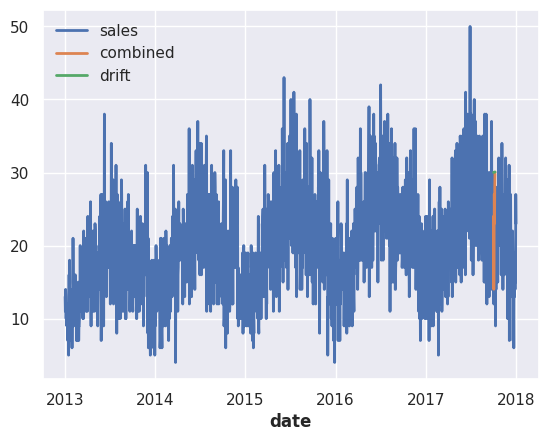

In [ ]:
seasonal_model.fit(filtered_train)
seasonal_forecast_7_g = seasonal_model.predict(7)

drift_model.fit(filtered_train)
drift_forecast_g = drift_model.predict(7)

combined_forecast_g = drift_forecast_g + seasonal_forecast_7_g - filtered_train.last_value()

series.plot()
combined_forecast_g.plot(label="combined")
drift_forecast_g.plot(label="drift")

**Висновки:**
1. Модель NaiveSeasonal це наївна модель для передбачення сезонності і не чутлива до тренду.
З огляду на те, що була визначена сезонність  7, 14, 21 - задаємо сезонність 7 і передбачаємо на таку саму сезонність.

2. Як бачили в попередніх завданнях у наших данних великий вплив має тренд.
3. Оскільки модель чутлива до викидів, то спробували її навчити на даних без викидів.

#Завдання 9

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [ ]:
print(
    f"MAPE на всьому  тренувальному наборі для моделі NaiveSeasonal + NaieDrift: {mape(series, combined_forecast):.2f}%."
)

MAPE на всьому  тренувальному наборі для моделі NaiveSeasonal + NaieDrift: 30.17%.


In [ ]:
print(
    f"MAPE для даних без викидів в тренувальному наборі для моделі NaiveSeasonal + NaieDrift: {mape(series, combined_forecast_g):.2f}%."
)

MAPE для даних без викидів в тренувальному наборі для моделі NaiveSeasonal + NaieDrift: 30.17%.


#XBGModel з darts

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [ ]:
# Побудова моделі XGBoost
model_xgb = XGBModel(
    lags=7,  # Використання останніх 7 спостережень для прогнозування
    output_chunk_length=1,  # Прогнозування на 1 крок вперед
    n_estimators=100,  # Кількість дерев у моделі
    max_depth=3,  # Максимальна глибина кожного дерева
    learning_rate=0.1,  # Коефіцієнт навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8  # Частка ознак, що використовуються для кожного дерева
)

##Загальний набір даних

In [ ]:
# Тренування моделі
model_xgb.fit(train)
pred_g = model_xgb.predict(7)
pred_g.values()

array([[23.911587],
       [19.699625],
       [22.478178],
       [25.121054],
       [23.258276],
       [26.342237],
       [26.794508]], dtype=float32)

In [ ]:
# Прогнозування
forecast_xgb_g = model_xgb.predict(len(val))

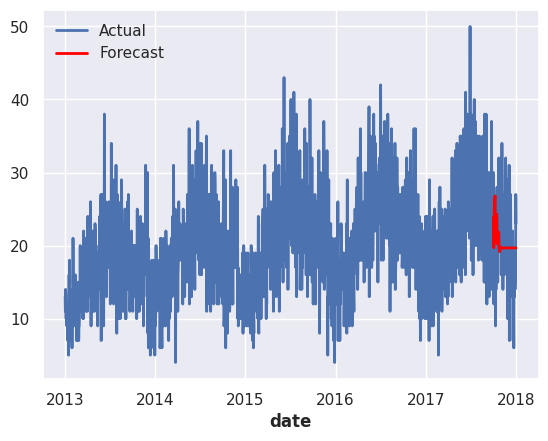

model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 29.08%


In [ ]:
# Візуалізація результатів
series.plot(label='Actual')
forecast_xgb_g.plot(label='Forecast', color='red')
plt.legend()
plt.show()

eval_forecast(model_xgb, val, forecast_xgb_g);

##Набір з доданими ознаками

In [ ]:
# Додавання ознак дати
train_transformed = enrich_with_date_features(train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(val.pd_dataframe().reset_index())

# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
test_transformed = scaler.transform(val)


In [ ]:
# Тренування моделі
model_xgb.fit(train_transformed)
pred_xgb = model_xgb.predict(7)
pred_xgb.values()

array([[0.43286052],
       [0.34129617],
       [0.40169948],
       [0.4591532 ],
       [0.4186582 ],
       [0.48570073],
       [0.49553263]], dtype=float32)

In [ ]:
#scaler.inverse_transform(pred_xgb)

<TimeSeries (DataArray) (date: 7, component: 1, sample: 1)> Size: 28B
array([[[23.911585]],

       [[19.699623]],

       [[22.478176]],

       [[25.121048]],

       [[23.258276]],

       [[26.342232]],

       [[26.7945  ]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 56B 2017-10-01 2017-10-02 ... 2017-10-07
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
# Прогнозування
#forecast_xgb = scaler.inverse_transform(model_xgb.predict(len(test_transformed)))

In [ ]:
# Прогнозування
forecast_xgb = model_xgb.predict(len(test_transformed))

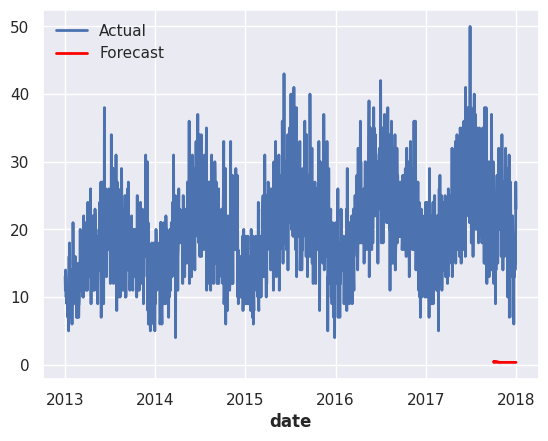

model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 46.93%


In [ ]:
# Візуалізація результатів
series.plot(label='Actual')
forecast_xgb.plot(label='Forecast', color='red')
plt.legend()
plt.show()

eval_forecast(model_xgb, test_transformed, forecast_xgb);

**Висновки:** Модель з доданими ознаками показала дуже поганий результат.

#ExponentialSmoothing

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [ ]:
fit_eval_model(ExponentialSmoothing())

model ExponentialSmoothing() obtains MAPE: 39.01%


#ARIMA

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

In [ ]:
model = ARIMA(p=7, d=1, q=1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


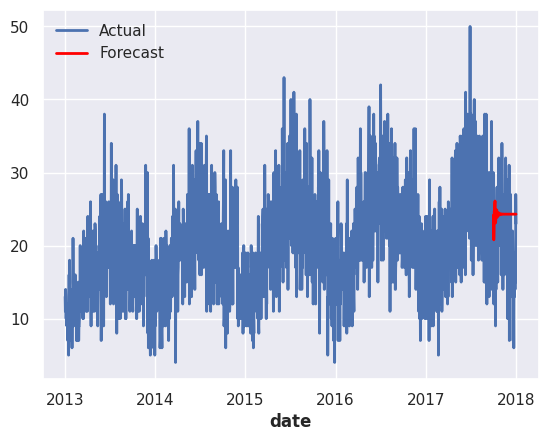

model ARIMA(p=7, q=1) obtains MAPE: 39.53%


In [ ]:
fit_and_plot(model, series, train, val)

#ARIMA з допомогою AutoARIMA

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

In [ ]:
# Побудова  моделі AutoArima
model_a  = AutoARIMA(start_p=1, max_p=31, start_q=1, seasonal=True)

AutoARIMA(add_encoders=None, start_p=1, max_p=31, start_q=1, seasonal=True)

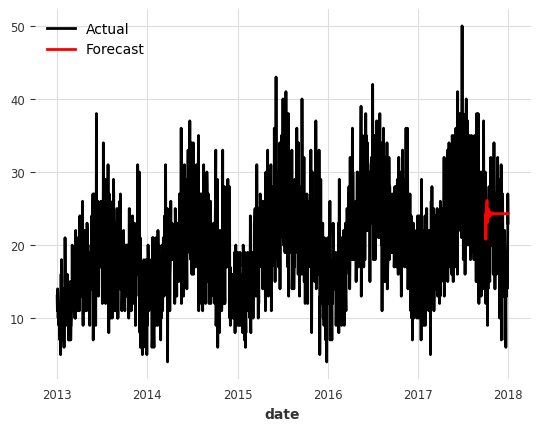

In [ ]:
# Тренування моделі AutoArima
model_a.fit(train)

display(model_a)

# Прогнозування
forecast_a = model_a.predict(len(val))

# Візуалізація результатів
plot_results(series, forecast_a)

In [ ]:
eval_forecast(model_a, val, forecast_a)

model AutoARIMA(start_p=1, max_p=31, start_q=1, seasonal=True) obtains MAPE: 39.53%


39.52818304458719

**Висновки:** Модель покращилась лише на 0,01%

#Prophet

14. Натренуйте модель Prophet та зробіть висновок про її якість.

In [15]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.3 MB/s eta 0:00:00


In [16]:
from skopt import gp_minimize
from skopt.space import Real, Categorical




# Простір параметрів для оптимізації
space = [
    Real(0.01, 0.5, name='changepoint_prior_scale'),
    Real(0.1, 10.0, name='seasonality_prior_scale'),
    Real(0.1, 10.0, name='holidays_prior_scale'),
    Real(0.8, 1.0, name='changepoint_range'),
    Categorical(['additive', 'multiplicative'], name='seasonality_mode')
]

# Функція, яку ми будемо мінімізувати
def objective(params):
    changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, changepoint_range, seasonality_mode = params
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        changepoint_range=changepoint_range,
        seasonality_mode=seasonality_mode
    )
    model.fit(train)
    forecast = model.predict(len(val))

    # Конвертуємо прогнозовані дані у TimeSeries
    forecast = forecast.slice_intersect(val)

    return mape(val, forecast)

# Використання Байєсівської оптимізації для підбору параметрів
result = gp_minimize(objective, space, n_calls=50, random_state=42)

# Найкращі параметри та їх MAPE
print(f"Найкращі параметри: {result.x}")
print(f"Найкращий MAPE: {result.fun:.2f}%")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph23d_35k/8ru5f0ny.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph23d_35k/rj8xalqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7009', 'data', 'file=/tmp/tmph23d_35k/8ru5f0ny.json', 'init=/tmp/tmph23d_35k/rj8xalqf.json', 'output', 'file=/tmp/tmph23d_35k/prophet_models7sei8cn/prophet_model-20240821193630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:36:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:36:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph23

Найкращі параметри: [0.35444426145476826, 10.0, 10.0, 0.8031651532536358, 'multiplicative']
Найкращий MAPE: 22.80%


In [17]:
# Оптимальні параметри, знайдені за допомогою gp_minimize
best_params = [0.35444426145476826, 10.0, 10.0, 0.8031651532536358, 'multiplicative']

# Розпакування параметрів
changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, changepoint_range, seasonality_mode = best_params

# Ініціалізація моделі Prophet з оптимальними параметрами
model_prophet = Prophet(
    changepoint_prior_scale=changepoint_prior_scale,
    seasonality_prior_scale=seasonality_prior_scale,
    holidays_prior_scale=holidays_prior_scale,
    changepoint_range=changepoint_range,
    seasonality_mode=seasonality_mode
)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph23d_35k/p5vf7h59.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph23d_35k/jvy5c0t1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30696', 'data', 'file=/tmp/tmph23d_35k/p5vf7h59.json', 'init=/tmp/tmph23d_35k/jvy5c0t1.json', 'output', 'file=/tmp/tmph23d_35k/prophet_modelor1s5hnw/prophet_model-20240821193814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:38:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:38:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


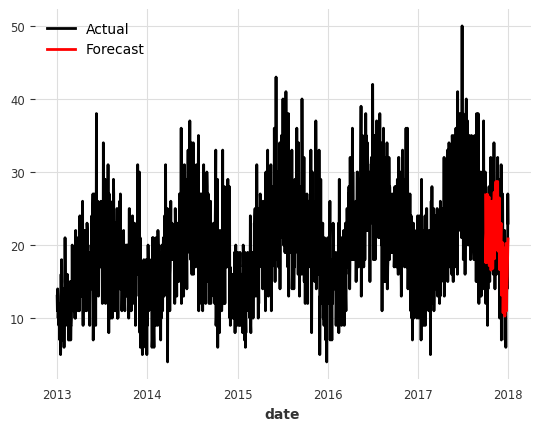

In [18]:
# Тренування моделі Prophet

model_prophet.fit(train)

# Прогнозування
forecast_prophet = model_prophet.predict(len(val))

# Візуалізація результатів
series.plot(label='Actual')
forecast_prophet.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [19]:
eval_forecast(model_prophet, val, forecast_prophet)

model Prophet(changepoint_prior_scale=0.35444426145476826, seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_range=0.8031651532536358, seasonality_mode=multiplicative) obtains MAPE: 22.80%


22.800668653565687

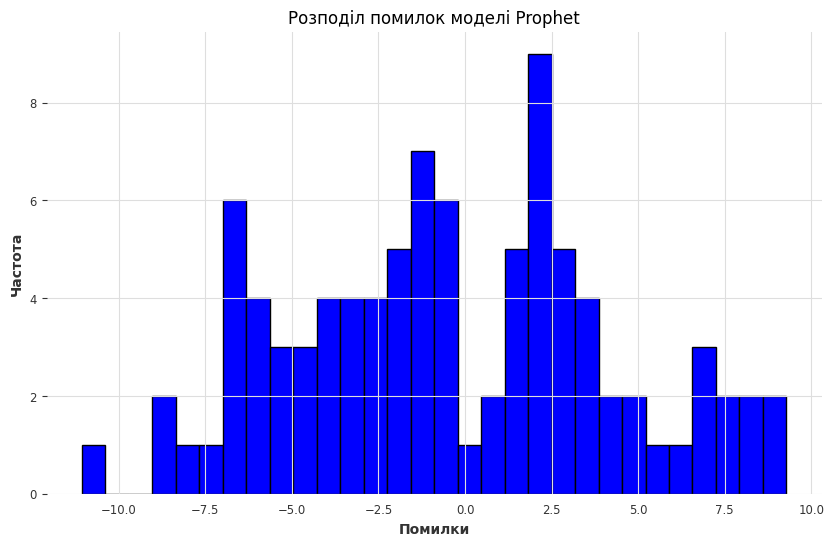

In [20]:
# Обчислення помилок (фактичне значення - прогноз)
errors = val.values() - forecast_prophet.values()

# Побудова гістограми розподілу помилок
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, color='blue', edgecolor='black')
plt.title('Розподіл помилок моделі Prophet')
plt.xlabel('Помилки')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Висновки:** Дана модель краща за попередні з МАРЕ 22.80%

#RNNModel

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [ ]:
model_rnn = RNNModel(
    model='LSTM',
    input_chunk_length=24,  # Зменште значення
    n_epochs=100,
    dropout=0.1,
    optimizer_kwargs={'lr': 0.001}
)

In [ ]:
# Побудова та тренування моделі LSTM
#model_rnn = RNNModel(model='LSTM', input_chunk_length=7, n_epochs=200)
model_rnn.fit(train)



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn    

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, dropout=0.1, training_length=24, input_chunk_length=24, n_epochs=100, optimizer_kwargs={'lr': 0.001})

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

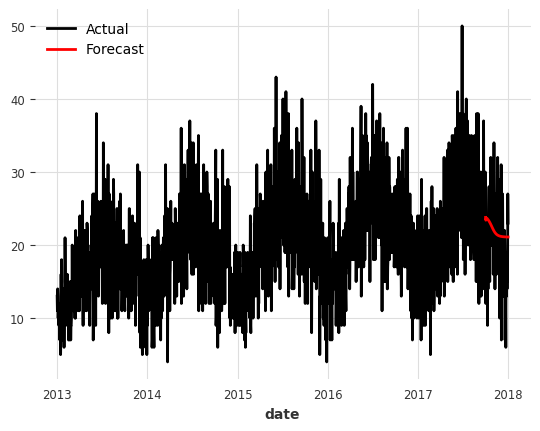

In [ ]:
# Прогнозування
forecast_rnn = model_rnn.predict(len(val))

# Візуалізація результатів
series.plot(label='Actual')
forecast_rnn.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [ ]:
eval_forecast(model_rnn, val, forecast_rnn)

model RNNModel(model=LSTM, dropout=0.1, input_chunk_length=24, n_epochs=100, optimizer_kwargs={'lr': 0.001}) obtains MAPE: 31.75%


31.75082603096238

**Висновки:** Дана модель  з МАРЕ 37.11%.

#Бектест для моделі Prophet

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

  0%|          | 0/336 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph23d_35k/dk_hv6ri.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph23d_35k/5tdn76wx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88562', 'data', 'file=/tmp/tmph23d_35k/dk_hv6ri.json', 'init=/tmp/tmph23d_35k/5tdn76wx.json', 'output', 'file=/tmp/tmph23d_35k/prophet_modelsdq37656/prophet_model-20240821193845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:38:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:38:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 1/336 [00:00<01:55,  2.89it/s]INFO:prophet:Disabling daily seasonality. Run prophet wi

MAPE = 19.50%


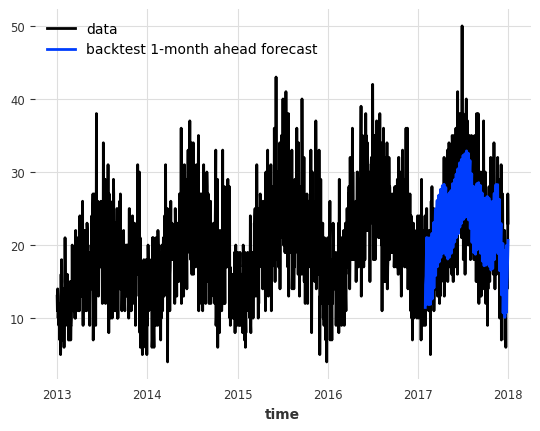

In [21]:
hfc_params = {
    "series": series,
    "start": pd.Timestamp("2017-01-01"),
    "forecast_horizon": 30,
    "verbose": True,
}

historical_fcast = model_prophet.historical_forecasts(last_points_only=True, **hfc_params)

series.plot(label="data")
historical_fcast.plot(label="backtest 1-month ahead forecast")
print(f"MAPE = {mape(series, historical_fcast):.2f}%")

  0%|          | 0/112 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph23d_35k/jtn6jtlw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph23d_35k/izcouyk4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5450', 'data', 'file=/tmp/tmph23d_35k/jtn6jtlw.json', 'init=/tmp/tmph23d_35k/izcouyk4.json', 'output', 'file=/tmp/tmph23d_35k/prophet_modelh35yh6qx/prophet_model-20240821194147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:41:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:41:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  1%|          | 1/112 [00:00<01:03,  1.75it/s]INFO:prophet:Disabling daily seasonality. Run prophet wit

MAPE = 31.98%


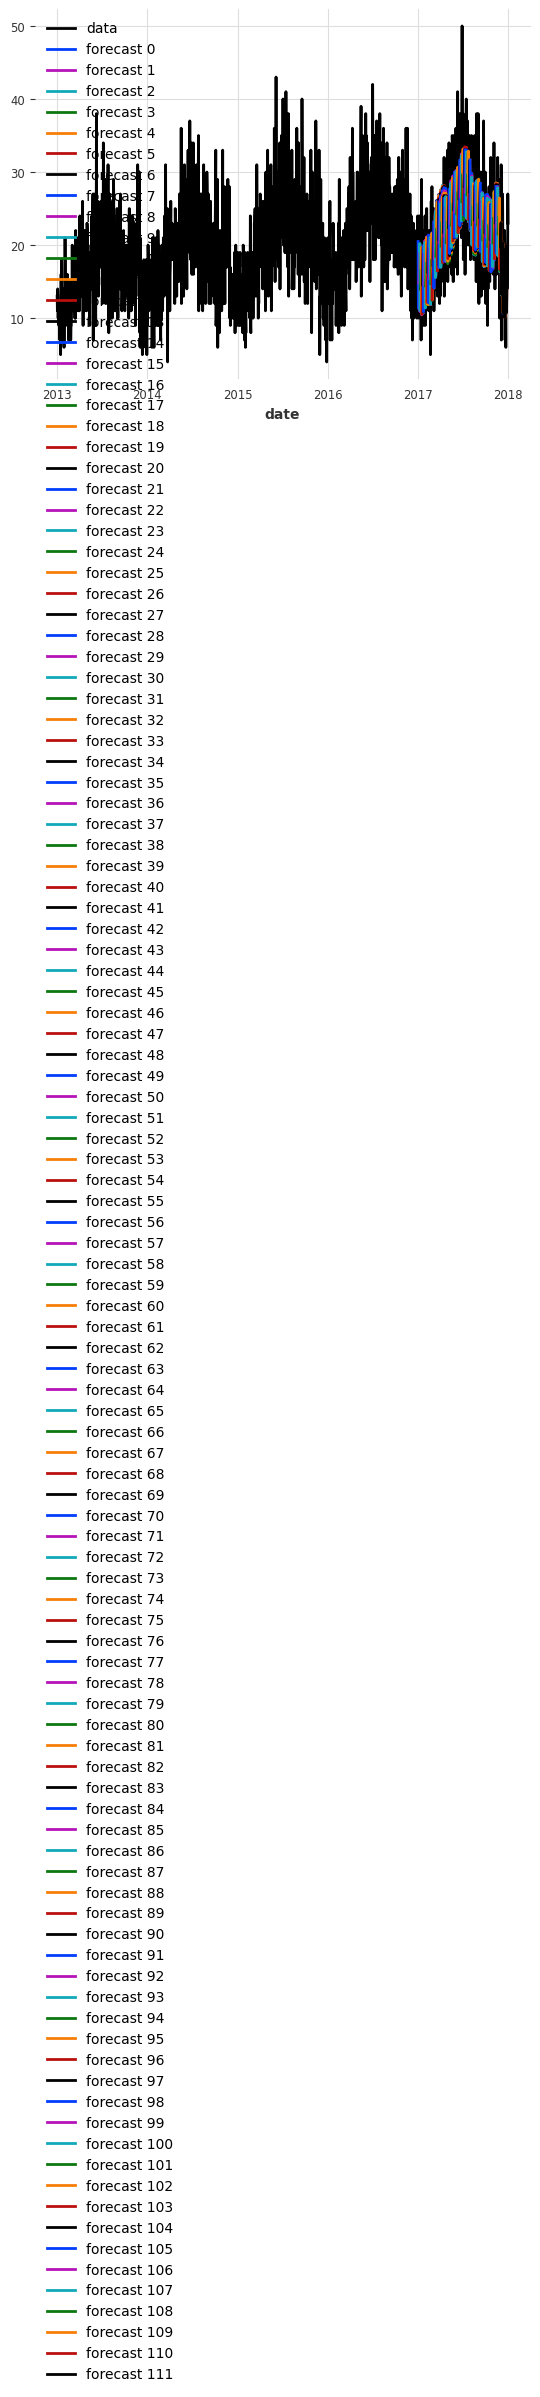

In [22]:
historical_fcast_all = model_prophet.historical_forecasts(last_points_only=False, stride=3, **hfc_params)

series.plot(label="data")
for idx, hfc in enumerate(historical_fcast_all):
    hfc.plot(label=f"forecast {idx}")


historical_fcast_all = concatenate(historical_fcast_all, axis=0, ignore_time_axis=True)
print(f"MAPE = {mape(series, historical_fcast_all):.2f}%")

  0%|          | 0/336 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph23d_35k/72z9odq1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph23d_35k/yr_70qwk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2103', 'data', 'file=/tmp/tmph23d_35k/72z9odq1.json', 'init=/tmp/tmph23d_35k/yr_70qwk.json', 'output', 'file=/tmp/tmph23d_35k/prophet_model_78xon8r/prophet_model-20240821194325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:43:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 1/336 [00:00<01:55,  2.90it/s]INFO:prophet:Disabling daily seasonality. Run prophet wit

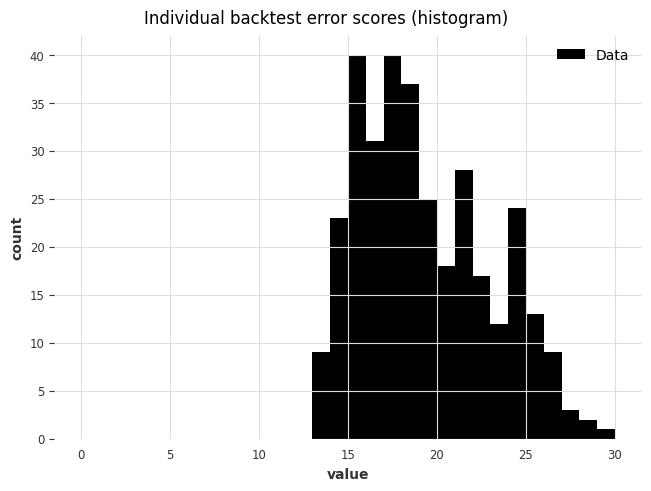

In [23]:
raw_errors = model_prophet.backtest(metric=mape, reduction=None, last_points_only=False, stride=1, **hfc_params)



plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

Всю варіантивність не вгадали, але виглядає непогано!

#Висновки

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

**Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід**

Найкращі результати показала модель Prophet з автоматичним підбором параметрів, включаючи сезонність.  Я би проаналізувала в циклі по кожному продукту в магазині з огляду на таке:
1. У нас відсутні підстави для групування товарів  за якоюсь з ознак.
2. У нас відсутні підстави для групування магазинів за якоюсь з ознак.
3. Для зручності використання збирала в датасети "Магазин": рядки "Товари", а колонки "Дні місяця".